In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Read input video

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import csv

In [0]:
N_FACE = 70
N_POSE = 8
FOLDER = './openpose/output/'
CSV_FOLDER = './drive/My Drive/636/sample_part5/csv/'
JSON_FOLDER = './drive/My Drive/636/sample_part8/json/'
FIG_FOLDER = './drive/My Drive/636/sample_part8/fig/'
MODEL_FOLDER = './drive/My Drive/636/model/part8/'
COL_NAMES = ['vid', 'frame']
COL_NAMES += ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]

In [0]:
df_list = []
for i in range(1, 6):
  df = pd.read_csv(CSV_FOLDER + str(i) + '.csv')
  df_list.append(df)

In [0]:
for i in range(5):
  df_list[i] = df_list[i][df_list[i].columns[2:]]

In [7]:
df_list

[         f_0      f_1      f_2      f_3  ...  p_12  p_13  p_14  p_15
 0    608.104  182.533  605.245  218.262  ...   0.0   0.0   0.0   0.0
 1    601.576  177.755  595.971  214.185  ...   0.0   0.0   0.0   0.0
 2    593.186  178.170  588.916  216.601  ...   0.0   0.0   0.0   0.0
 3    591.117  173.803  586.904  208.908  ...   0.0   0.0   0.0   0.0
 4    584.937  173.060  582.150  209.282  ...   0.0   0.0   0.0   0.0
 ..       ...      ...      ...      ...  ...   ...   ...   ...   ...
 349  590.188  183.864  555.773  258.128  ...   0.0   0.0   0.0   0.0
 350  580.039  184.403  539.941  255.488  ...   0.0   0.0   0.0   0.0
 351  556.902  183.543  510.500  248.927  ...   0.0   0.0   0.0   0.0
 352  563.328  185.735  523.478  260.001  ...   0.0   0.0   0.0   0.0
 353    0.000    0.000    0.000    0.000  ...   0.0   0.0   0.0   0.0
 
 [354 rows x 156 columns],
             f_0      f_1         f_2  ...     p_13     p_14     p_15
 0    150.909000  116.604  151.716000  ...    0.000    0.000 

Reshape Data into Segments and Prepare for Keras

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, fps, TIME_STEP):
  slices = []
  ts = []
  for i in range(df.shape[0]):
    ts.append(i/fps)
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, df.shape[1]))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  ts_arr = np.asarray(ts, dtype= np.float32)
  return slices_arr, ts_arr

Load model and weight

In [9]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten
from keras.callbacks import History, EarlyStopping
from keras.models import load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, Activation, MaxPooling1D, Conv2D, Activation, MaxPooling2D, Dropout, Dense, LSTM, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.layers import TimeDistributed

Draw figure

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

def drawplt(time, pred, fig_name):
  plt.figure(figsize=(12,8))
  # plt.plot(time, pred, 'b', label='prediction', markersize=1)
  plt.plot(time, pred, 'b', label='prediction', markersize=3, color='red')
  plt.title('Prediction over time')
  my_y_ticks = np.arange(0, 1, 0.1)
  plt.yticks(my_y_ticks)
  plt.legend() 
  plt.savefig(fig_name)


Generate json

In [0]:
import json
def to_json(filepath):
  np_pred = np.array((ts_arr, y_pred.flatten())).T
  pred_list = np_pred.tolist()
  pred_dict = {"cry":pred_list}
  pred_json = json.dumps(pred_dict)
  with open(filepath, 'w') as json_file:
    json_file.write(pred_json)

Automation

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 15, 128)       73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 6, 128)        

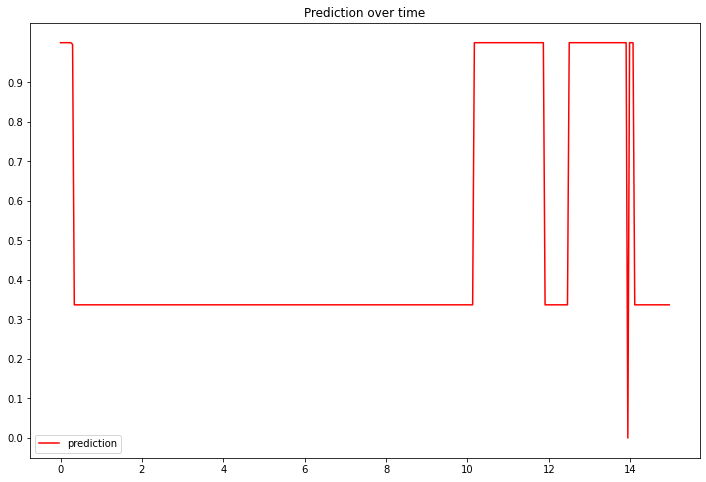

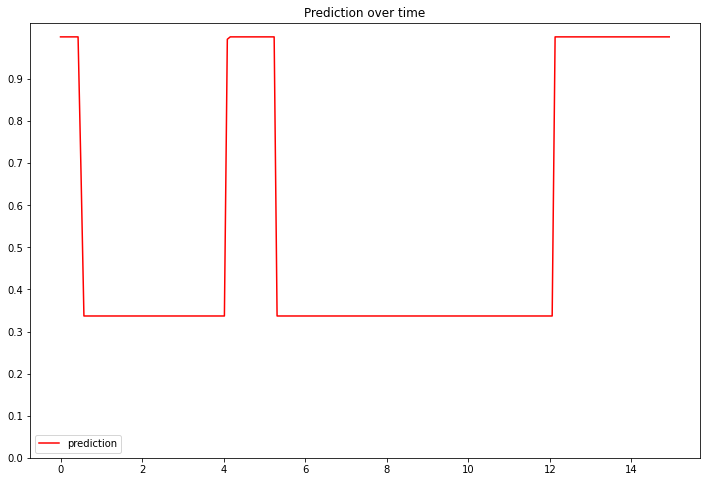

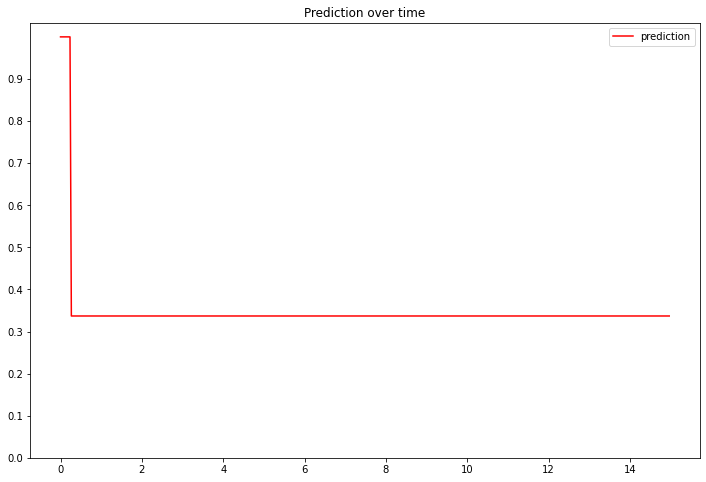

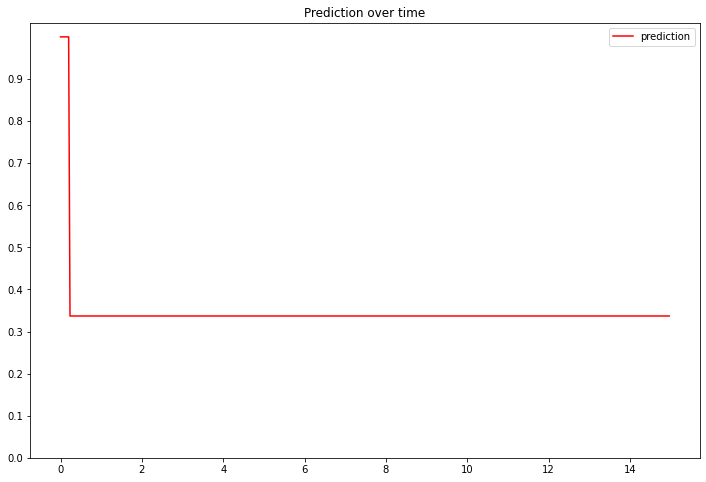

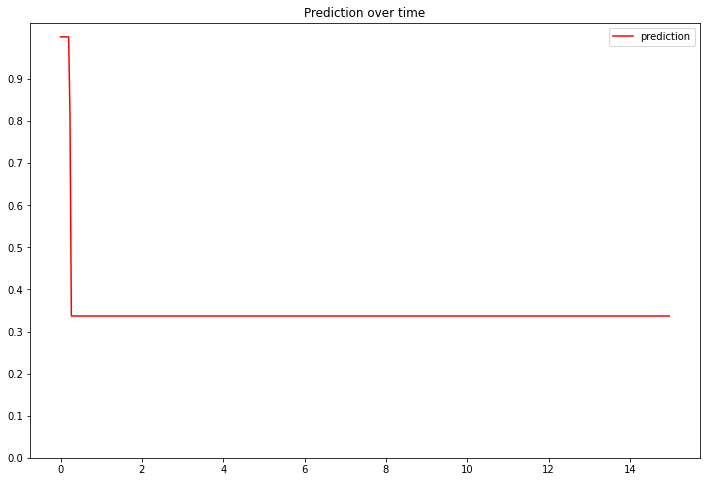

In [23]:
model = load_model(MODEL_FOLDER + 'big_7859.h5')
model.summary()
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr = X_arr.reshape(X_arr.shape[0], 40, 39, 1)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'big_7859' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'big_7859' + str(i + 1) + '.json'
  to_json(json_name)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 15, 128)       73856     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 6, 128)        

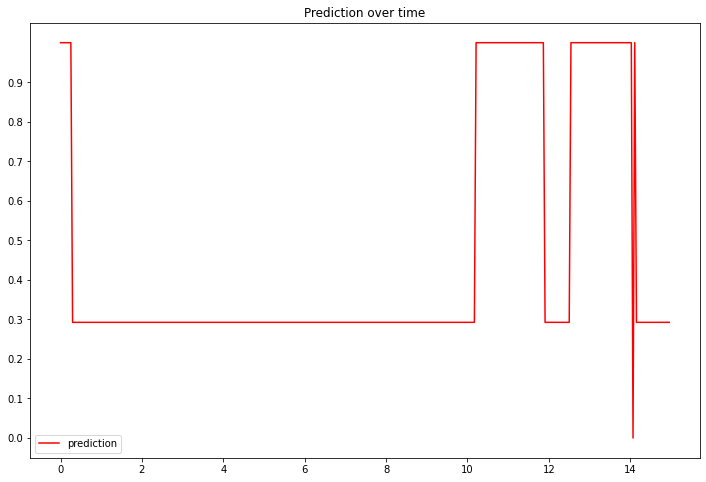

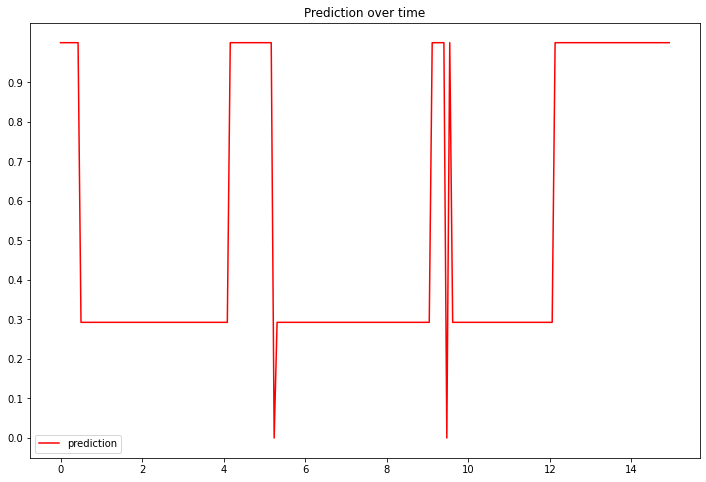

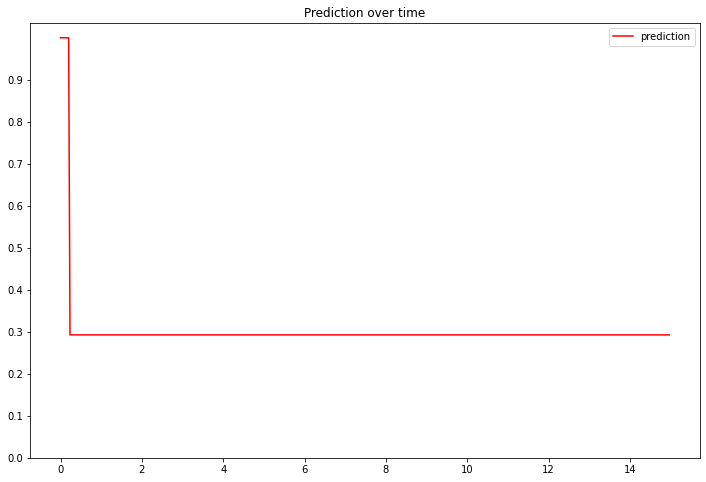

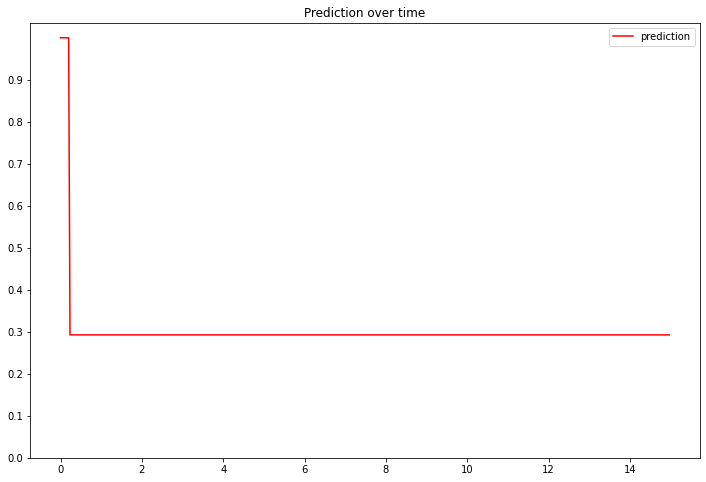

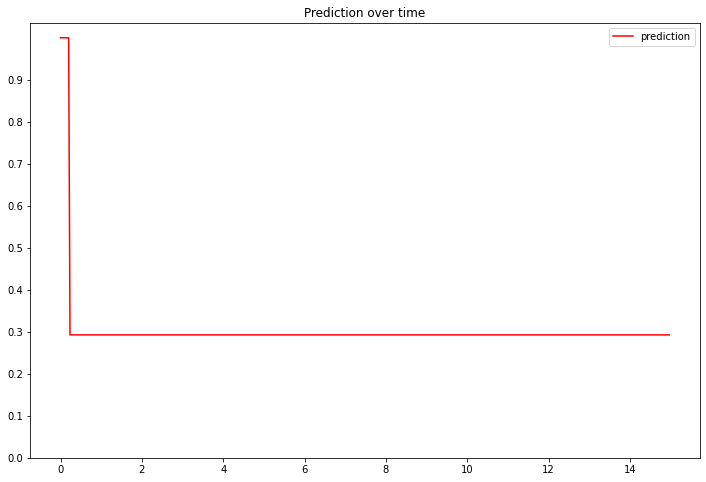

In [22]:
model = load_model(MODEL_FOLDER + 'big_7571.h5')
model.summary()
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr = X_arr.reshape(X_arr.shape[0], 40, 39, 1)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'big_7571' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'big_7571' + str(i + 1) + '.json'
  to_json(json_name)

In [0]:
model = load_model(MODEL_FOLDER + 'model1_7058.h5')
model.summary()
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model1_7058' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'model1_7058' + str(i + 1) + '.json'
  to_json(json_name)

OSError: ignored

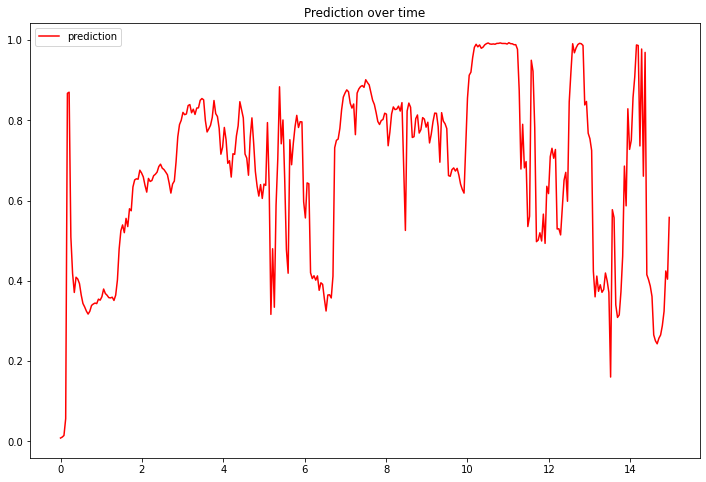

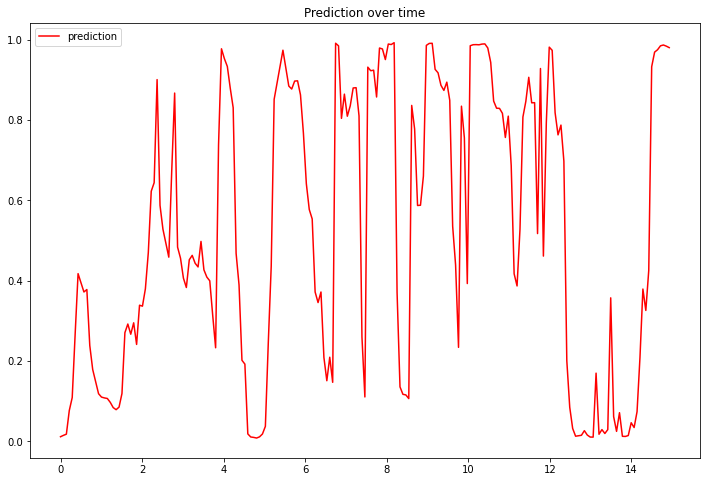

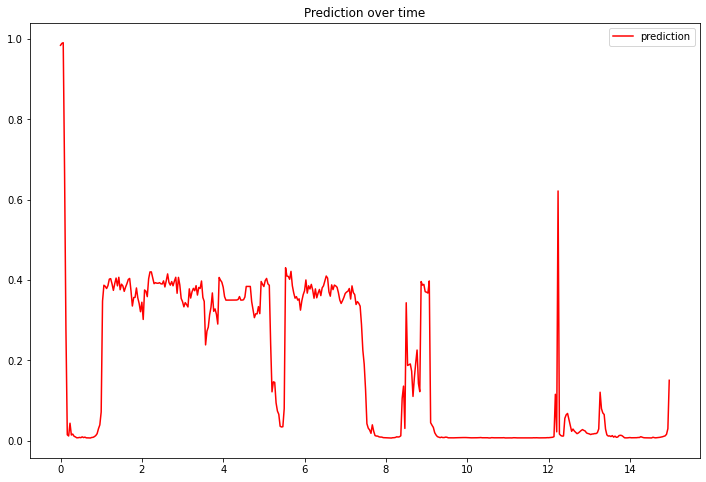

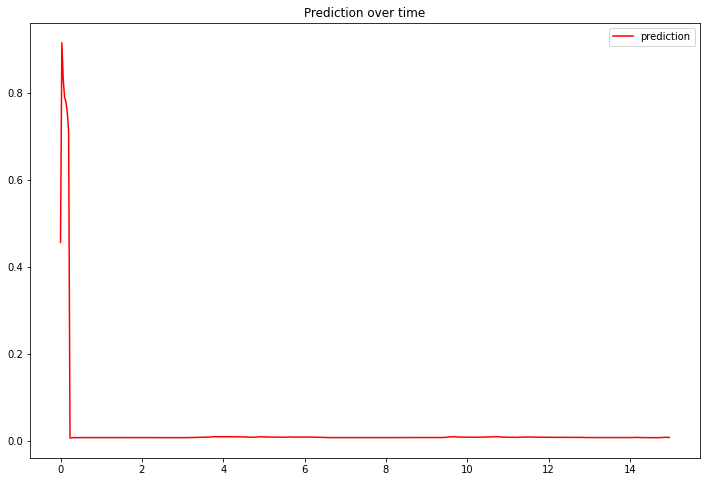

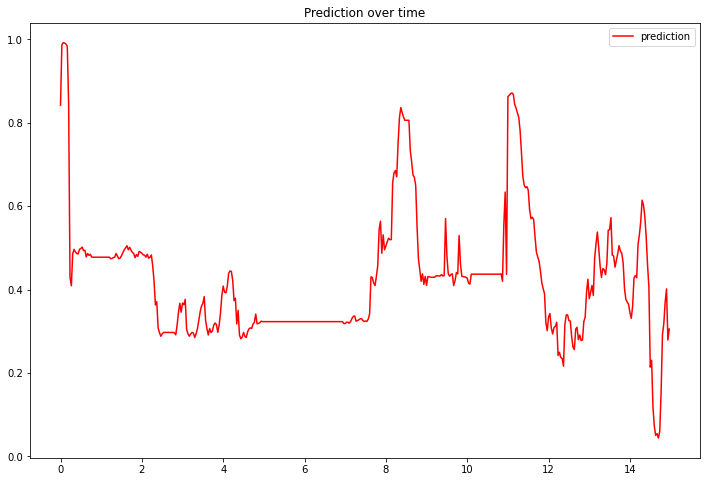

In [0]:
model = load_model(MODEL_FOLDER + 'model5_6921.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model5_6921' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'model5_6921' + str(i + 1) + '.json'
  to_json(json_name)

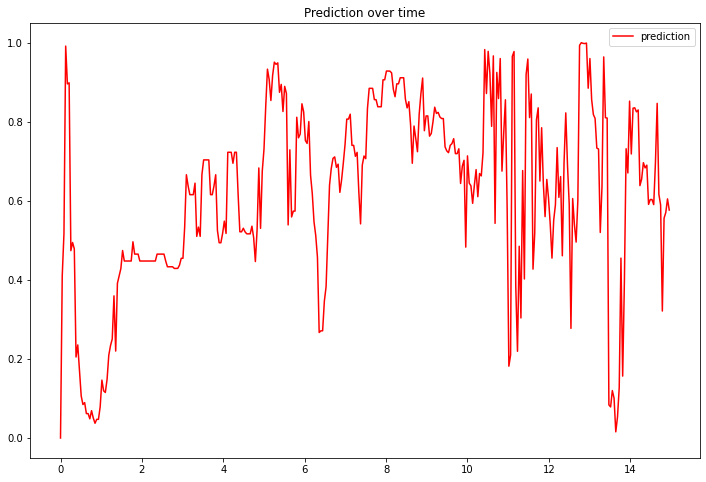

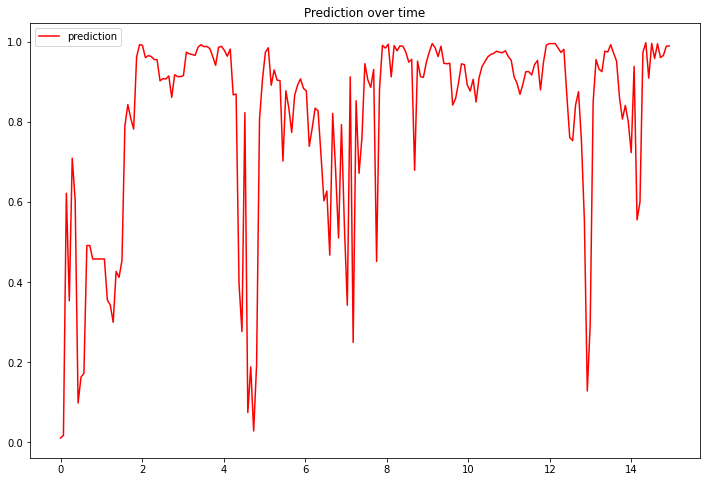

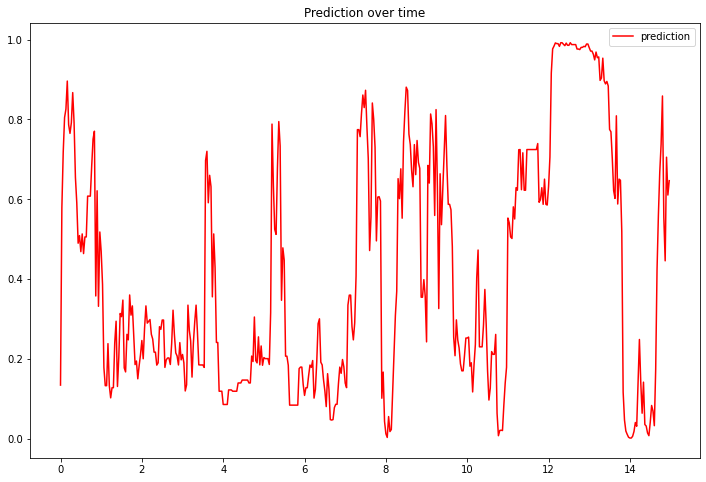

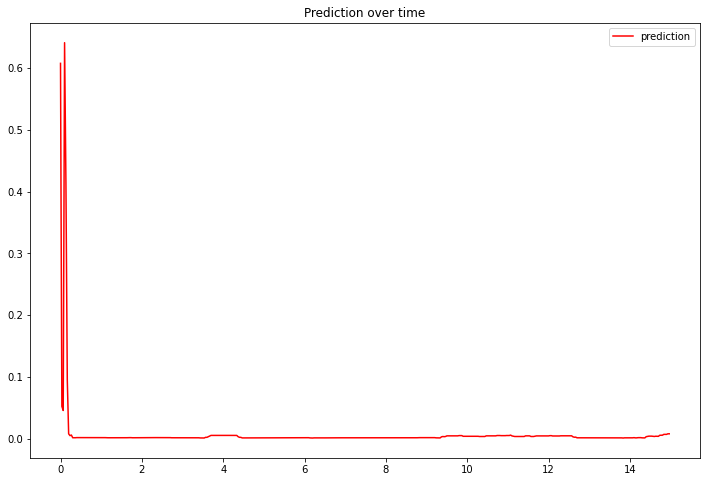

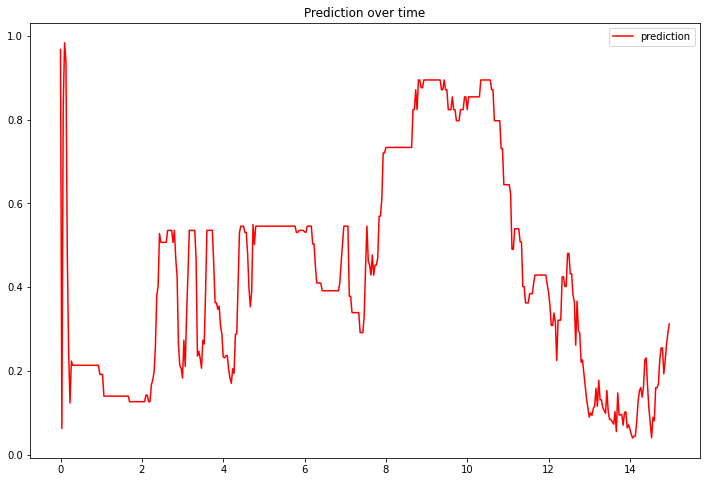

In [0]:
model = load_model(MODEL_FOLDER + 'model7_1_7037.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model7_1_7037' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'model7_1_7037' + str(i + 1) + '.json'
  to_json(json_name)

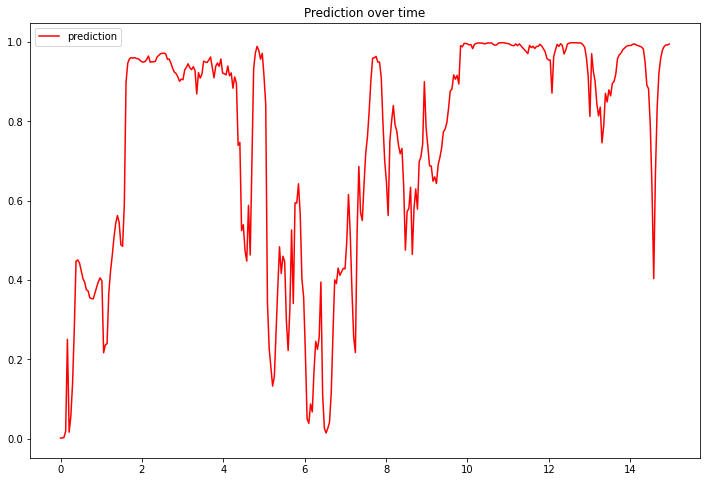

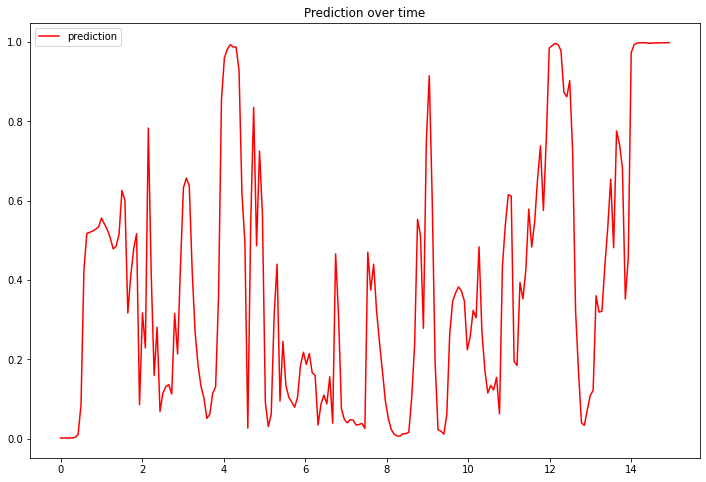

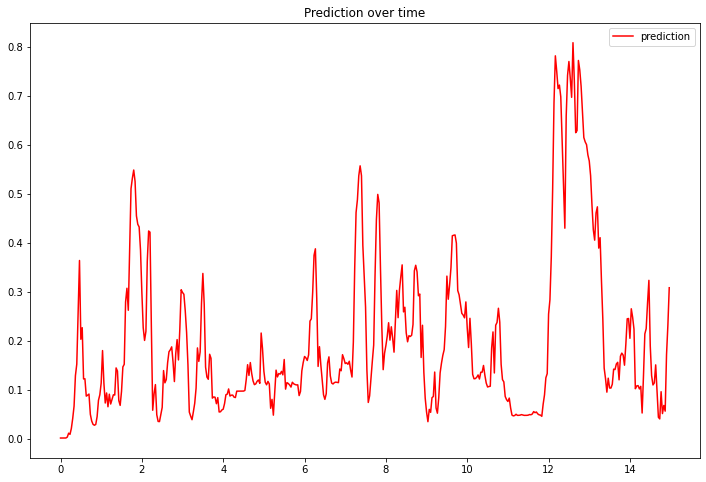

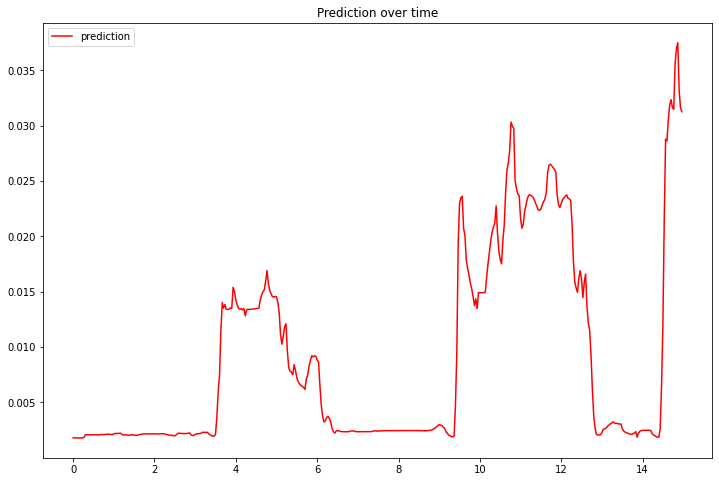

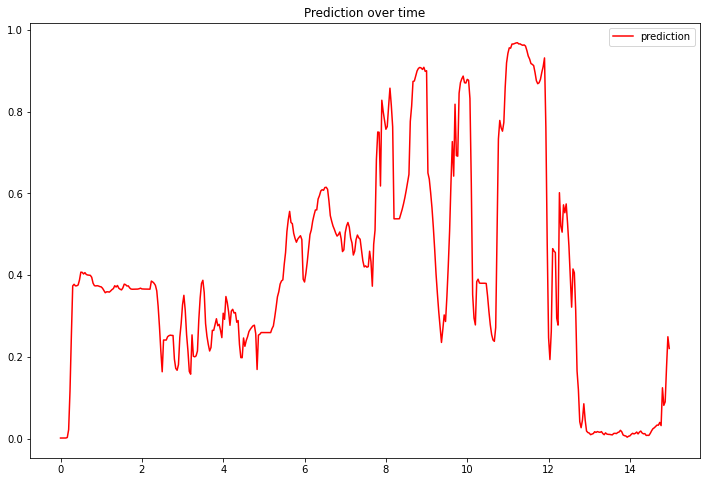

In [0]:
model = load_model(MODEL_FOLDER + 'model1_6884.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model1_6884' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)
  # output json file
  json_name = JSON_FOLDER + 'model1_6884' + str(i + 1) + '.json'
  to_json(json_name)

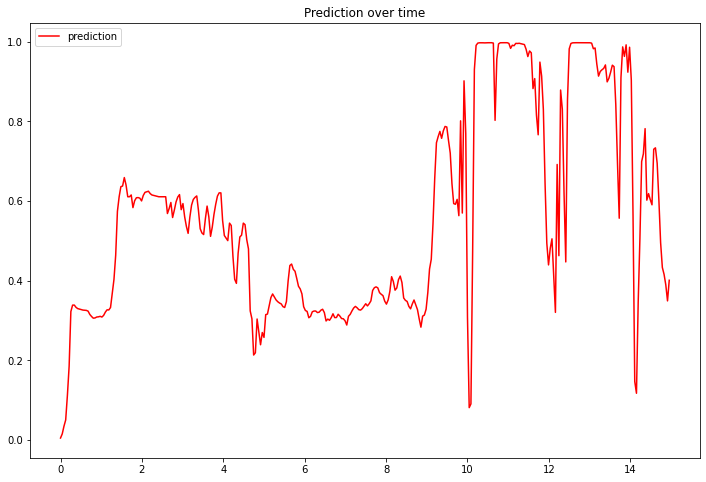

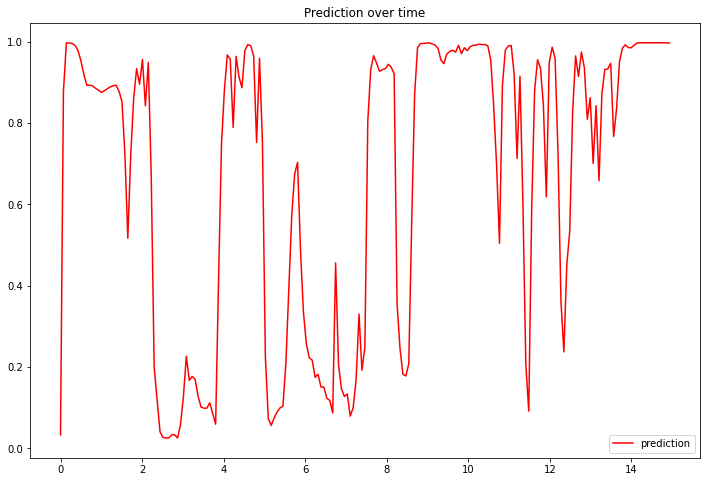

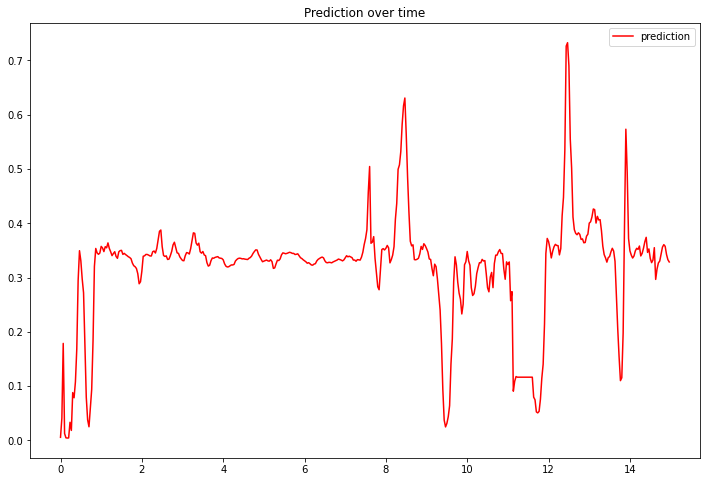

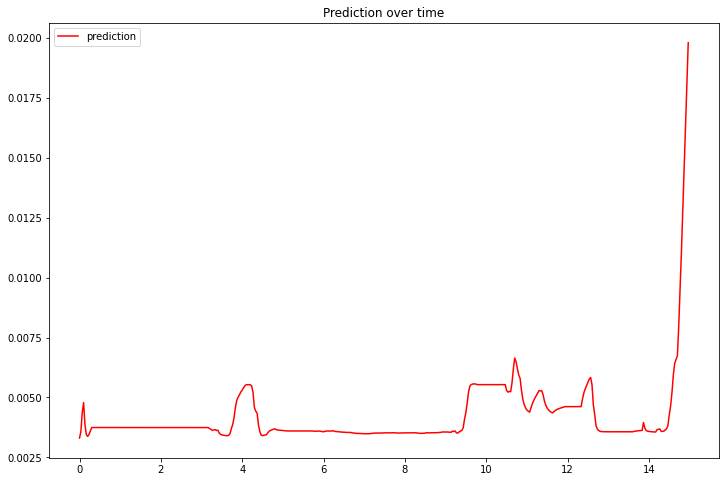

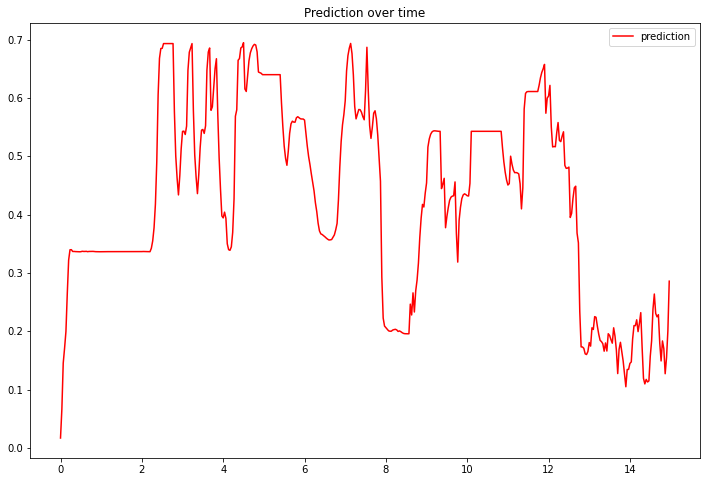

In [0]:
model = load_model(MODEL_FOLDER + 'model6_6644.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr_r = X_arr.reshape((X_arr.shape[0], 1, 10, 156))
   # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model6_6644' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)

In [0]:
ls './drive/My Drive/636/model/part8'

model1_6884.h5  model5_6921.h5    model6_6644.h5    model7_6252.h5
model1_7058.h5  model6_1_5671.h5  model7_1_7037.h5  model8_5856.h5


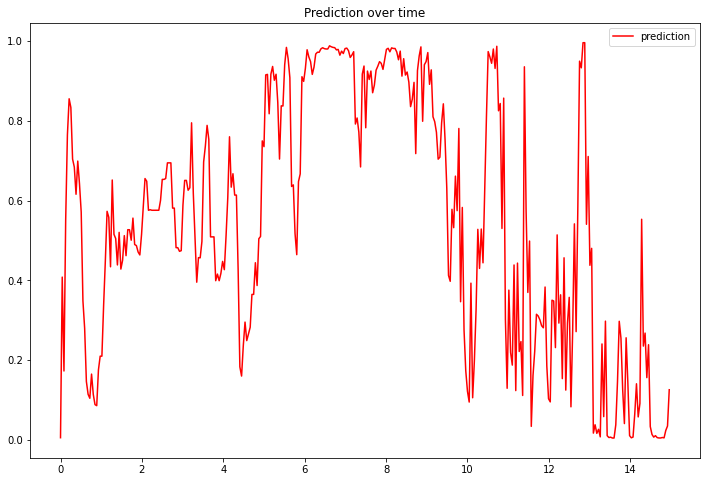

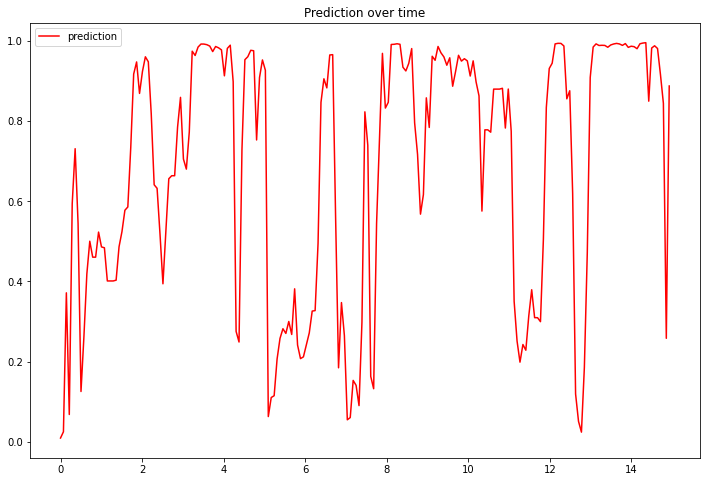

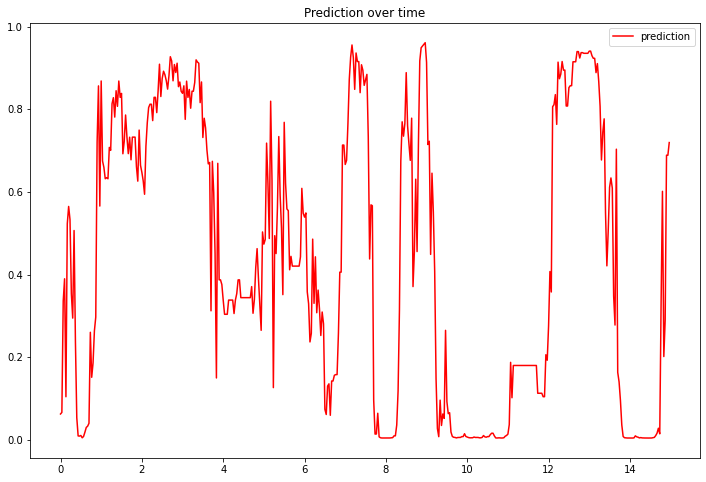

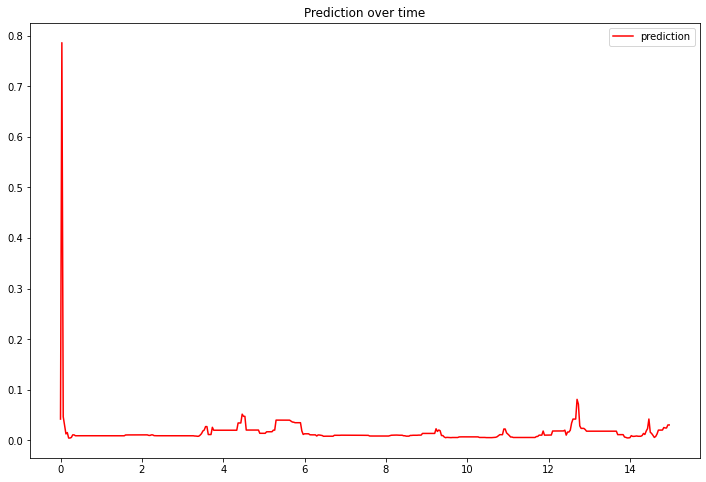

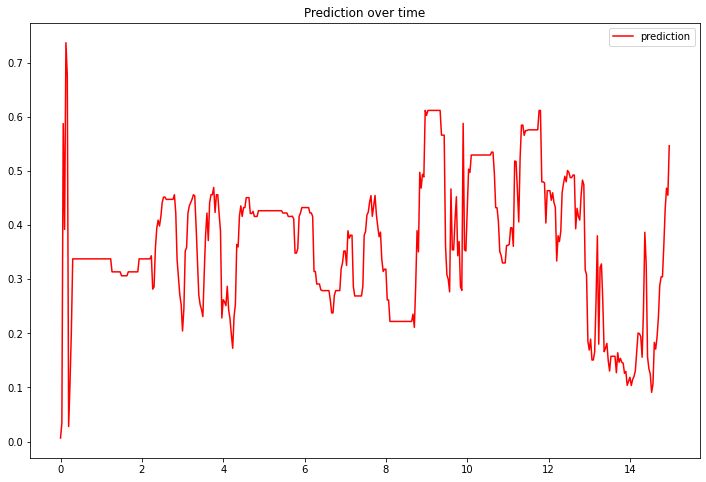

In [0]:
model = load_model(MODEL_FOLDER + 'model8_5856.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr_r = X_arr.reshape((X_arr.shape[0], 1, 10, 156))
   # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model8_5856' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)

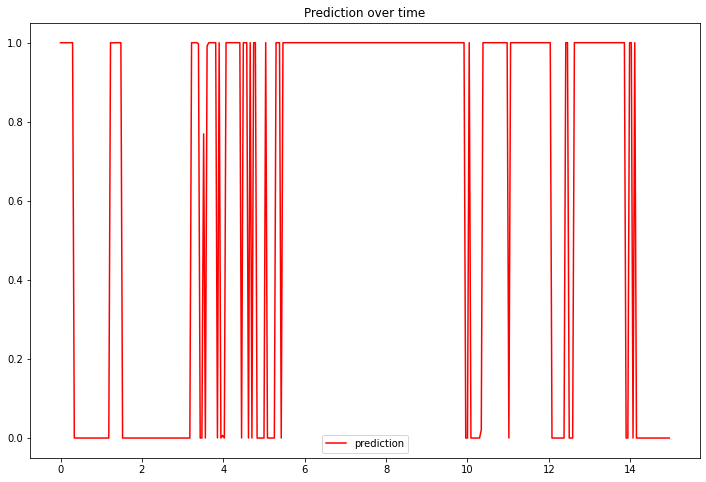

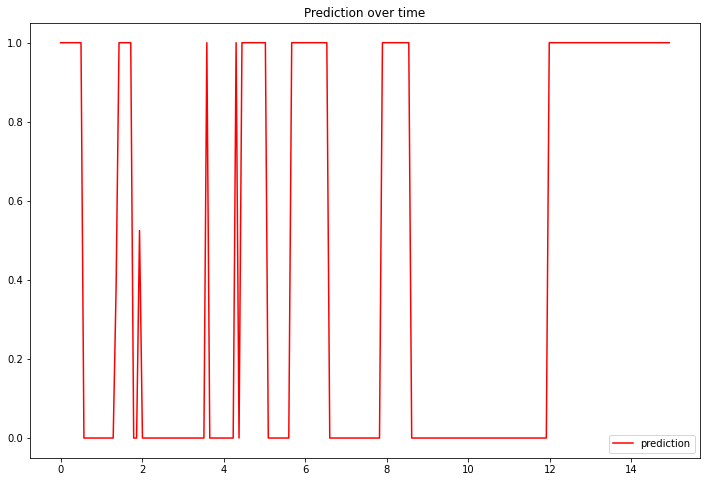

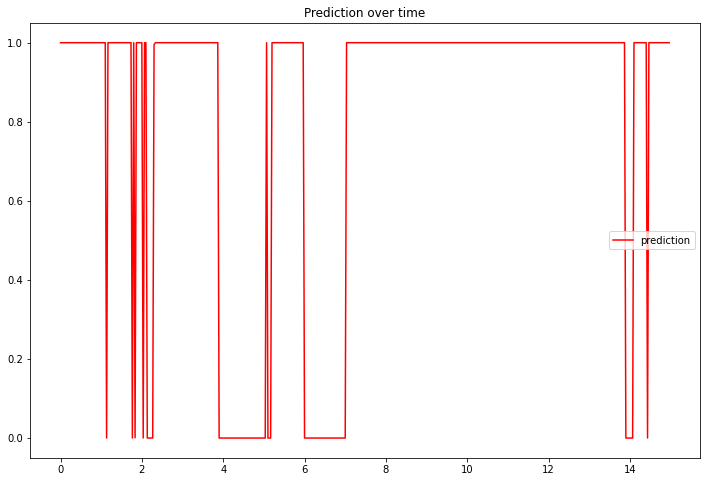

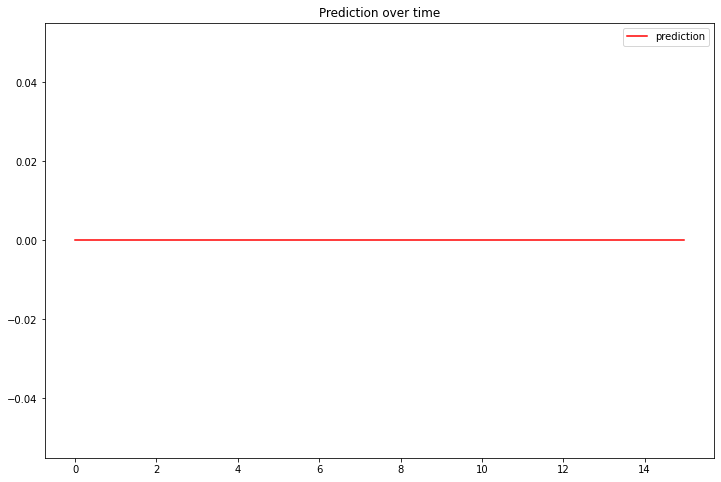

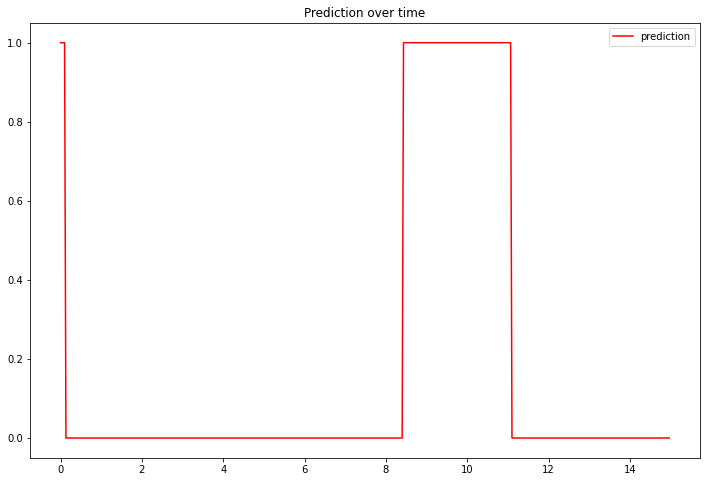

In [0]:
model = load_model(MODEL_FOLDER + 'model10_6336.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr_r = X_arr.reshape((X_arr.shape[0], 1, 10, 156))
   # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model10_6336' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)

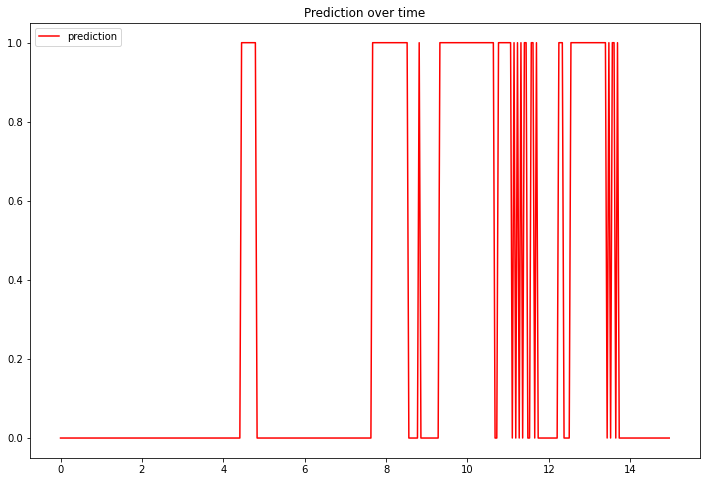

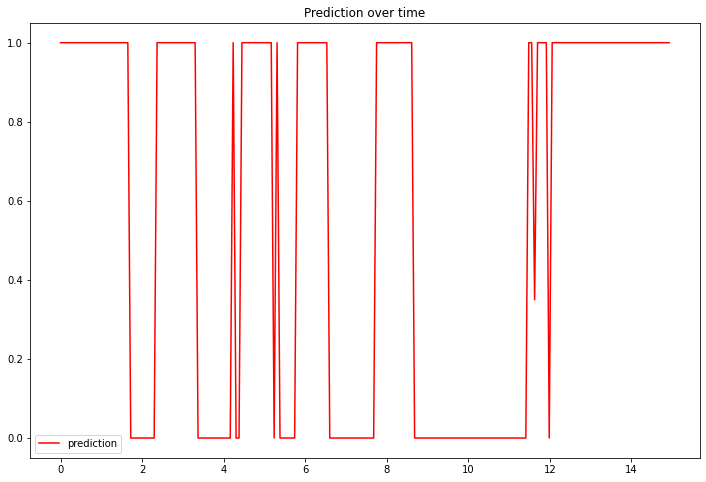

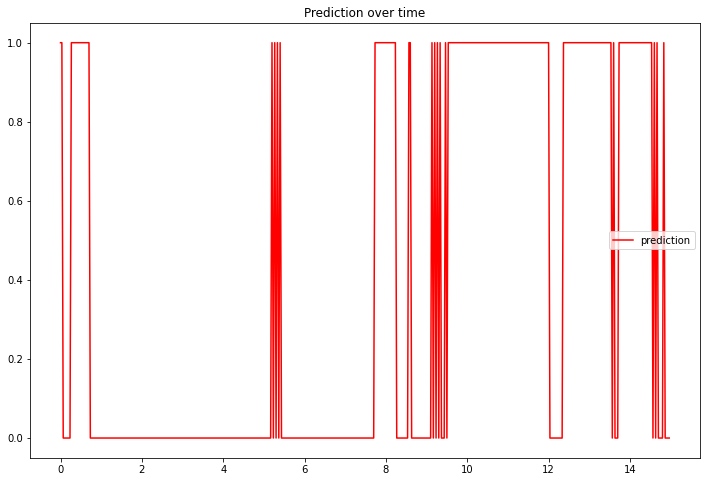

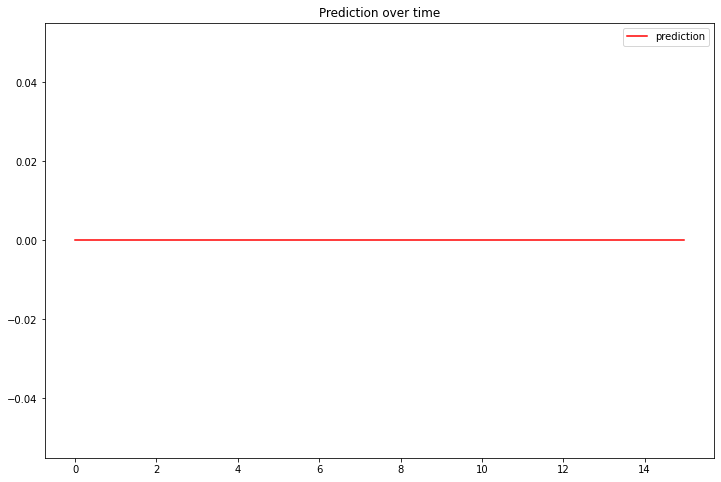

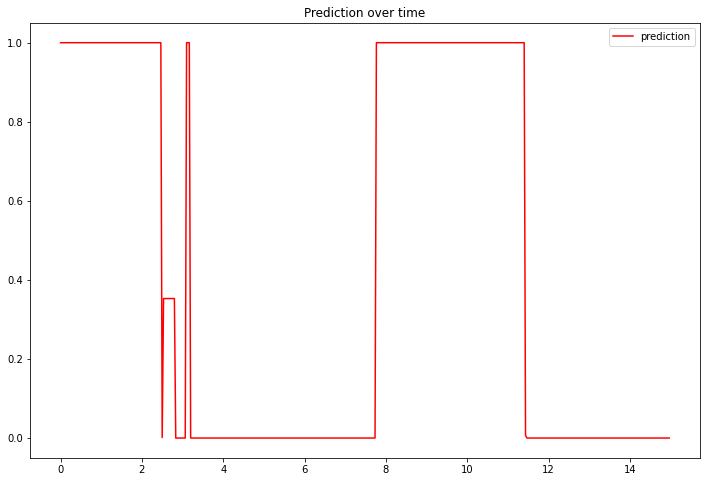

In [0]:
model = load_model(MODEL_FOLDER + 'model10_6590.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr_r = X_arr.reshape((X_arr.shape[0], 1, 10, 156))
   # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model10_6590' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)

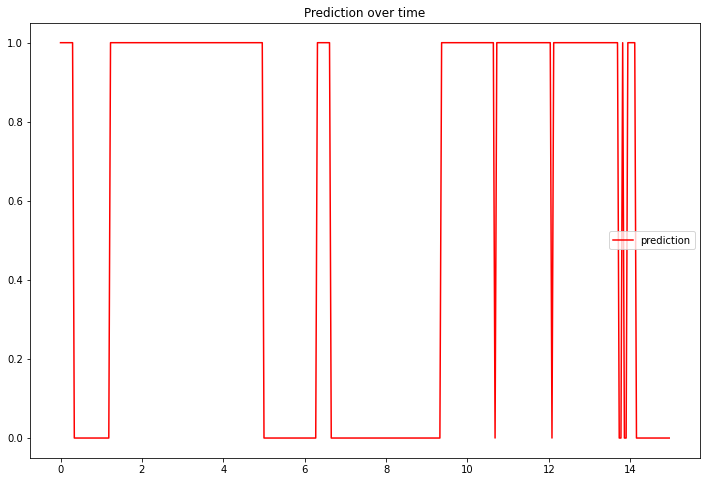

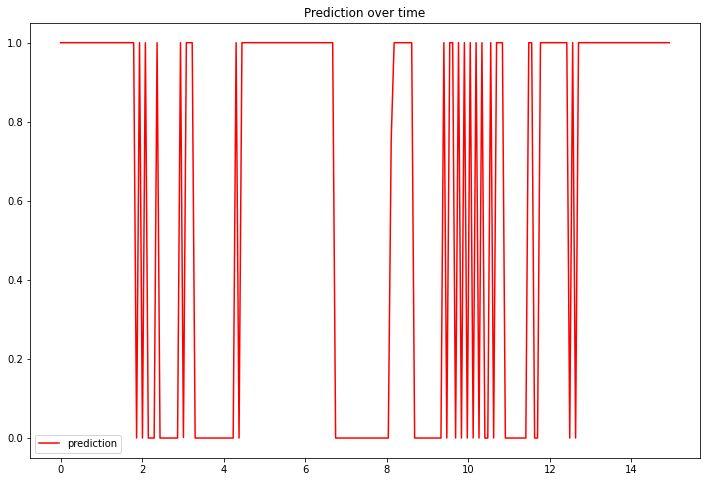

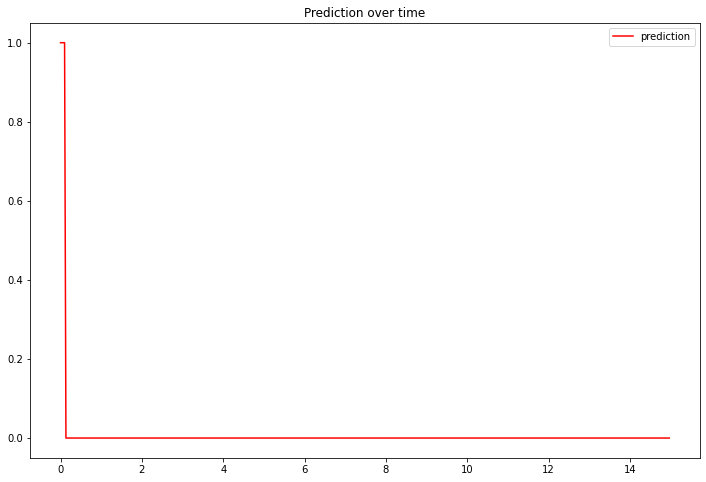

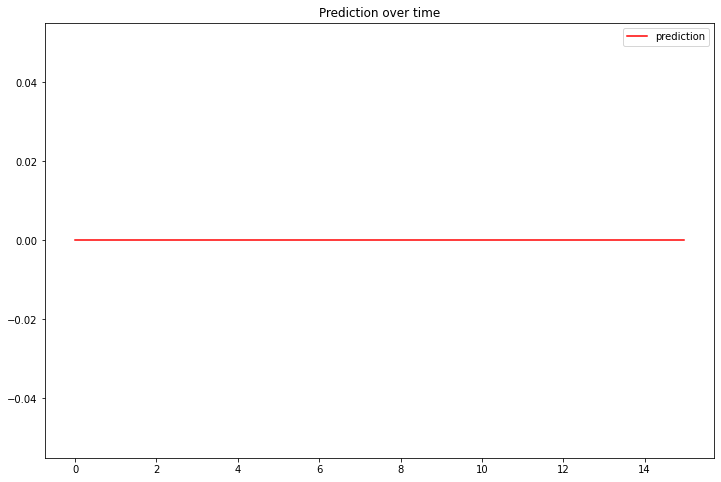

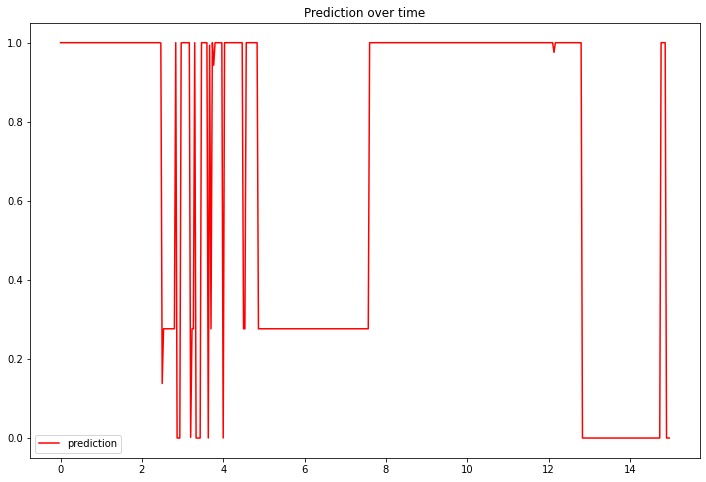

In [0]:
model = load_model(MODEL_FOLDER + 'model10_6364.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_slices(df, fps, 10)
  X_arr_r = X_arr.reshape((X_arr.shape[0], 1, 10, 156))
   # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  fig_name = FIG_FOLDER + 'model10_6364' + str(i + 1) + '.png'
  drawplt(ts_arr, y_pred, fig_name)